# WOAQ Data Visualization

In [40]:
# Import libraries

import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib
import matplotlib.pyplot as plt
import pynmea2
import numpy as np
import re
import io
import datetime
import pytz
import warnings

%matplotlib inline

## Functions for loading and joining data

In [21]:
def parse_gps_sentence(sentence):
    """Parse an NMEA 0183 formatted data sample.
    Parameters
    ----------
    sentence : str
        A NMEA 0183 formatted "sentence" with the prefix $GPRMC
        (Recommended minimum specific GPS/Transit data)
    Returns
    -------
    A pynmea2.types.talker.RMC object
    References
    ----------
    http://aprs.gids.nl/nmea (NMEA Sentence Information)
    """
    try:
        gps = pynmea2.parse(sentence)
        if not gps.is_valid:
            gps = None

    except pynmea2.nmea.SentenceTypeError:
        gps = None

    return gps


In [22]:
def sentence_to_dict(sentence):
    """Convert an NMEA sentence object to a dict of values
    Parameters
    ----------
    sentence : pynmea2.types.talker.RMC
    Returns
    -------
    A dict containing the key-value pair for each field in the
    NMEA sentence
    """
    sentence_dict = {}
    for field in sentence.fields:
        field_attribute_name = field[1]
        sentence_dict[field_attribute_name] = getattr(sentence, field_attribute_name)

    return sentence_dict

In [23]:
def combine_date_and_time(date_series, time_series):
    """Combine a date and time series into a datetime series
    Parameters
    ----------
    date_series : pandas Series
    time_series : pandas Series
    Returns
    -------
    A pandas Series of datetimes
    """
    datetimes = []
    for date, time in zip(date_series.values, time_series.values):
        dt = pd.datetime.combine(date, time)
        datetimes.append(dt)

    return datetimes

In [24]:
def degree_minute_to_decimal(degmin):
    """Convert a geospatial location from degrees/minute notation to decimal
    degrees
    Parameters
    ----------
    degmin : float
        A longitude or latitude value expressed as (degrees * 100 + minutes)
        e.g., latitude -12217.45234 is 122° 17.45234' W
    Returns
    -------
    The longitude/latitude as a decimal
    """
    degrees = degmin // 100
    minutes = degmin - (degrees * 100)
    return degrees + minutes / 60

In [25]:
def load_gps(filepath):
    """Load and condition data from a GPS raw data file
    Parameters
    ----------
    filepath : str
        GPS file path
    Returns
    -------
    A pandas DataFrame
    """
    gps = []

    with open(filepath) as gps_file:
        contents = gps_file.read()

    for sample in contents.splitlines():
        if sample.startswith("$GPRMC"):
            gps_sample = parse_gps_sentence(sample)
            gps_dict = sentence_to_dict(gps_sample)
            gps.append(gps_dict)

    gps = pd.DataFrame(gps)

    sample_times = combine_date_and_time(gps.datestamp, gps.timestamp)
    sample_times = pd.DatetimeIndex(sample_times, tz="UTC")
    gps["time"] = sample_times
    gps.sort_values(by="time", inplace=True)

    gps["lon"] = gps.lon.apply(float)
    gps["lat"] = gps.lat.apply(float)

    gps["lon"] = gps.lon.apply(degree_minute_to_decimal)
    gps["lat"] = gps.lat.apply(degree_minute_to_decimal)

    longitudes = []
    for _, (lon, lon_dir) in gps[["lon", "lon_dir"]].iterrows():
        if lon_dir == "E":
            longitudes.append(lon)
        else:
            longitudes.append(-lon)

    latitudes = []
    for _, (lat, lat_dir) in gps[["lat", "lat_dir"]].iterrows():
        if lat_dir == "N":
            latitudes.append(lat)
        else:
            latitudes.append(-lat)

    gps["lon"] = longitudes
    gps["lat"] = latitudes

    return gps

In [26]:
def load_dustrak(filepath, tz):
    """Load and condition data from a DusTrak raw data file
    Parameters
    ----------
    filepath : str
        Dustrak csv file path
    Returns
    -------
    A dict of metadata information and a pandas DataFrame of measurement values
    """

    with open(filepath) as file:
        meta, values = re.split("\n\n", file.read())

    metadata = {}
    for row in meta.splitlines():
        key, value = row.strip().split(",")
        metadata[key] = value

    data = pd.read_csv(io.StringIO(values))

    if data.columns[0] != "Elapsed Time [s]":
        raise ValueError("First column must be elapsed time in seconds")

    start_time = " ".join([metadata["Test Start Date"], metadata["Test Start Time"]])
    start_time = datetime.datetime.strptime(start_time, "%m/%d/%Y %I:%M:%S %p")

    local_timezone = pytz.timezone(tz)
    start_time = local_timezone.localize(start_time)
    start_time = start_time.astimezone(pytz.timezone("UTC"))

    sample_interval_minutes = metadata["Test Interval [M:S]"].split(":")[0]
    if sample_interval_minutes != "0":
        raise NotImplementedError("Minute sampling intervals not supported")

    sample_offsets = np.array(data["Elapsed Time [s]"], dtype="timedelta64[s]")
    sample_times = pd.Timestamp(start_time) + pd.to_timedelta(sample_offsets)

    data["time"] = sample_times
    data.sort_values(by="time", inplace=True)

    return metadata, data

In [27]:
def join(air_quality, gps, tolerance=3.0):
    """Join a DusTrak and a GPS tables into a single table.
    The DusTrak device collects time stamps and air quality measurements, but no geospatial
    information. Scientists will also take a GPS device on their sessions that records timestamps
    and longitudes/latitudes. Merge the two files by matching timestamps.
    Parameters
    ----------
    dustrak : pandas DataFrame
    gps : pandas DataFrame
    tz : str
    tolerance : numeric
        How far away (in seconds) can a air quality measurement be from a GPS measurement to be
        linked to it
    Returns
    -------
    A pandas DataFrame containing the sample time (in UTC), longitude, latitude, and measurement
    """
    joined_data = pd.merge_asof(
        air_quality,
        gps,
        on="time",
        direction="nearest",
        tolerance=pd.Timedelta(f"{tolerance}s"),
    )

    invalid_indices = joined_data[["lon", "lat", "Mass [mg/m3]"]].isnull().any(1)
    joined_data = joined_data[~invalid_indices]

    n_dropped = invalid_indices.sum()

    if n_dropped > 0:
        message = f"{n_dropped} air quality samples dropped that were not within {tolerance} seconds of a GPS sample."
        warnings.warn(message)

    joined_data = joined_data[["time", "Mass [mg/m3]", "lon", "lat"]]
    joined_data.rename(columns={"Mass [mg/m3]": "measurement"}, inplace=True)

    return joined_data

## Load and join sample data

In [28]:
# Load a GPS file into a dataframe

gps = load_gps('data/GPS_example.log')
gps.head()

/Users/brooks/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]


,timestamp,status,lat,lat_dir,lon,lon_dir,spd_over_grnd,true_course,datestamp,mag_variation,mag_var_dir,time
0,19:59:28.192000,A,37.803360,N,-122.294687,W,0.74,41.15,2014-07-16,,,2014-07-16 19:59:28.192000+00:00
1,19:59:29.192000,A,37.803362,N,-122.294685,W,0.55,17.25,2014-07-16,,,2014-07-16 19:59:29.192000+00:00
2,19:59:30.193000,A,37.803365,N,-122.294683,W,0.59,14.75,2014-07-16,,,2014-07-16 19:59:30.193000+00:00
3,19:59:31,A,37.803388,N,-122.294668,W,0.56,16.33,2014-07-16,,,2014-07-16 19:59:31+00:00
4,19:59:32,A,37.803395,N,-122.294665,W,1.02,20.41,2014-07-16,,,2014-07-16 19:59:32+00:00


In [29]:
# Load a dustrak file into a dataframe

metadata, dustrak = load_dustrak("data/Dustrak_example.csv", "US/Pacific")
print(metadata)
print(dustrak.shape)
dustrak.head()

{'Instrument Name': 'DustTrak II', 'Model Number': '8530', 'Serial Number': '8530100707', 'Firmware Version': '3.0', 'Calibration Date': '06/18/2013', 'Test Name': '8530C_2-5_001', 'Test Start Time': '01:01:07 PM', 'Test Start Date': '07/16/2014', 'Test Length [D:H:M]': '0:0:54', 'Test Interval [M:S]': '0:1', 'Mass Average [mg/m3]': '0.012', 'Mass Minimum [mg/m3]': '0.001', 'Mass Maximum [mg/m3]': '0.157', 'Mass TWA [mg/m3]': '0.001', 'Photometric User Cal': '1.00', 'Flow User Cal': '0.00', 'Errors': '', 'Number of Samples': '3259'}
(3259, 5)


,Elapsed Time [s],Mass [mg/m3],Alarms,Errors,time
0,1,0.012,NaN,NaN,2014-07-16 20:01:08+00:00
1,2,0.013,NaN,NaN,2014-07-16 20:01:09+00:00
2,3,0.012,NaN,NaN,2014-07-16 20:01:10+00:00
3,4,0.012,NaN,NaN,2014-07-16 20:01:11+00:00
4,5,0.011,NaN,NaN,2014-07-16 20:01:12+00:00


In [30]:
# Join the dustrak and gps data into a dataframe

df = join(dustrak, gps)
print(df.shape)
df.head()

(3259, 4)


,time,measurement,lon,lat
0,2014-07-16 20:01:08+00:00,0.012,-122.294732,37.803300
1,2014-07-16 20:01:09+00:00,0.013,-122.294732,37.803300
2,2014-07-16 20:01:10+00:00,0.012,-122.294730,37.803300
3,2014-07-16 20:01:11+00:00,0.012,-122.294732,37.803302
4,2014-07-16 20:01:12+00:00,0.011,-122.294733,37.803303


In [33]:
# Convert to a gdf

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs='EPSG:4326')
print(gdf.shape)
gdf.head()

(3259, 5)


,time,measurement,lon,lat,geometry
0,2014-07-16 20:01:08+00:00,0.012,-122.294732,37.803300,POINT (-122.29473 37.80330)
1,2014-07-16 20:01:09+00:00,0.013,-122.294732,37.803300,POINT (-122.29473 37.80330)
2,2014-07-16 20:01:10+00:00,0.012,-122.294730,37.803300,POINT (-122.29473 37.80330)
3,2014-07-16 20:01:11+00:00,0.012,-122.294732,37.803302,POINT (-122.29473 37.80330)
4,2014-07-16 20:01:12+00:00,0.011,-122.294733,37.803303,POINT (-122.29473 37.80330)


## Data Visualization

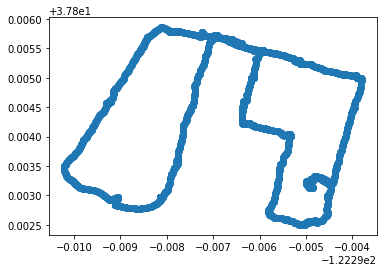

In [39]:
# Basic plot for the gps location data

gdf.plot();

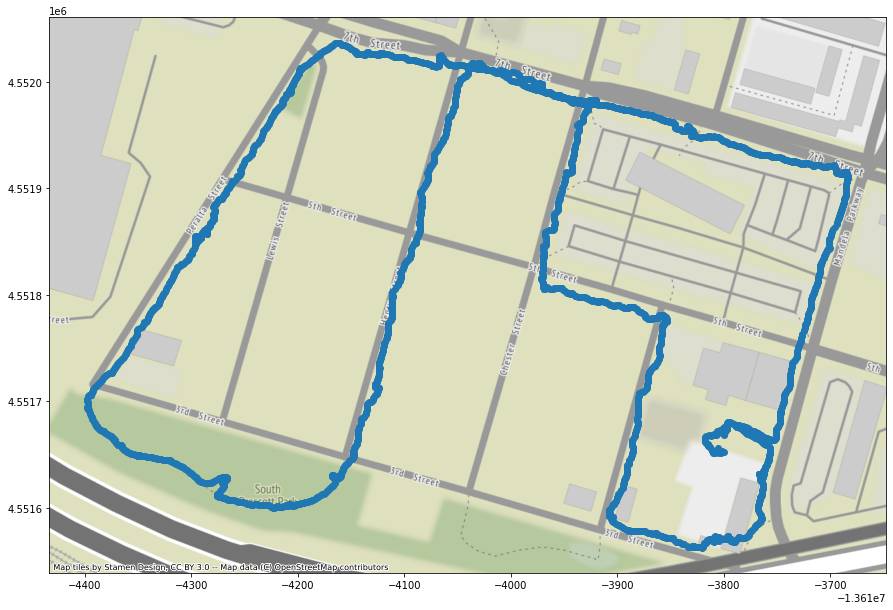

In [53]:
# Add a basemap

ax = gdf.to_crs('EPSG:3857').plot(figsize=(15, 15))
cx.add_basemap(ax)

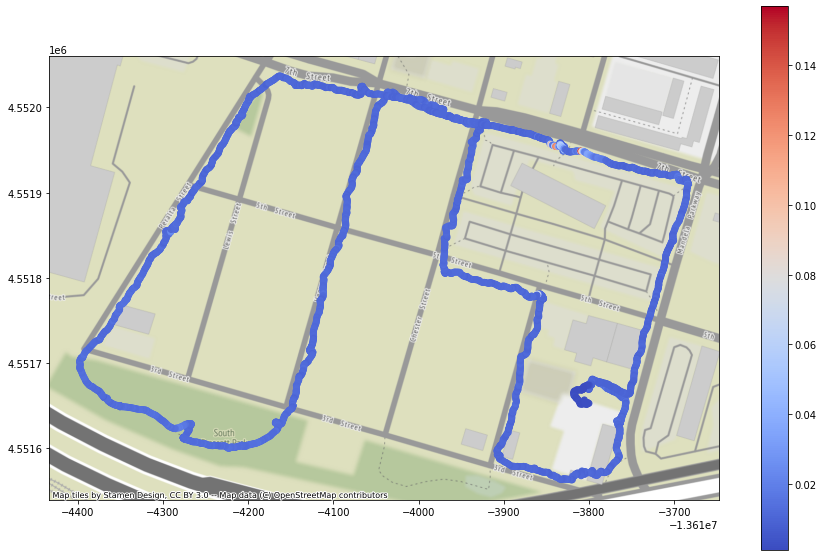

In [58]:
# Proportional color map set to the air quality measurements

ax = gdf.to_crs('EPSG:3857').plot(figsize=(15, 10), 
                                  column='measurement', 
                                  cmap='coolwarm',
                                  legend=True)
cx.add_basemap(ax)

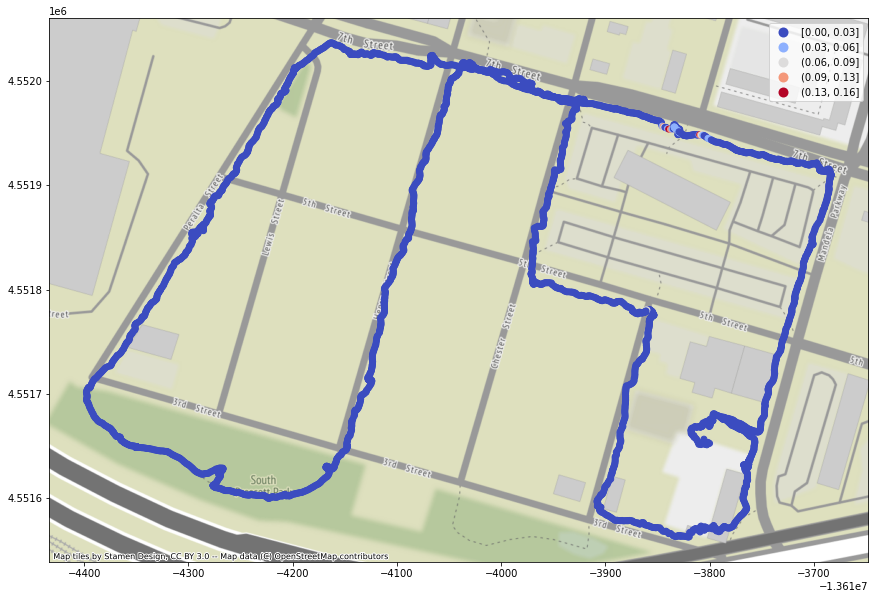

In [60]:
# Graduated color map with equal intervals classification scheme

ax = gdf.to_crs('EPSG:3857').plot(figsize=(15, 10), 
                                  column='measurement', 
                                  cmap='coolwarm',
                                  scheme="equalinterval",
                                  legend=True)
cx.add_basemap(ax)

/Users/brooks/opt/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/Users/brooks/opt/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


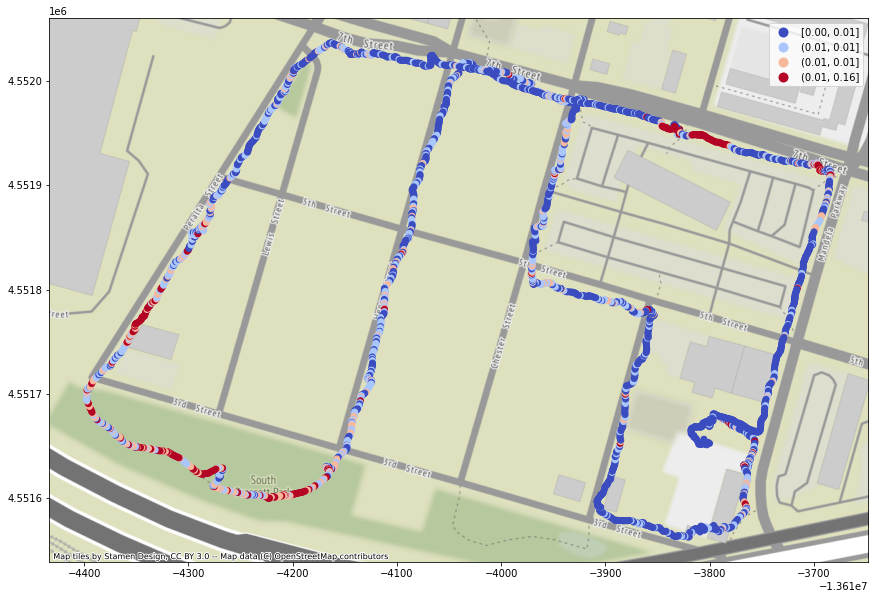

In [61]:
# Graduated color map with quantiles classification scheme

ax = gdf.to_crs('EPSG:3857').plot(figsize=(15, 10), 
                                  column='measurement', 
                                  cmap='coolwarm',
                                  scheme="quantiles",
                                  legend=True)
cx.add_basemap(ax)